# Imports

In [74]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json
import yfinance as yf
#from pandas_datareader import data

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data

In [75]:
# retrieve historical data for specific company
# VSCO = Victoria Secret
ticker = 'VSCO'
start = '2010-01-01'
end = '2025-03-20'
stock_data = yf.download(ticker, start, end)

stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,VSCO,VSCO,VSCO,VSCO,VSCO
Date,,,,,
2021-07-21,42.500000,55.000000,39.994999,55.000000,96100
2021-07-22,40.900002,42.750000,39.790001,42.750000,401200
2021-07-23,42.139999,42.200001,40.990002,41.980000,114400
2021-07-26,41.200001,41.500000,40.060001,40.200001,22000
2021-07-27,41.435001,41.520000,41.099998,41.500000,83000


# Linear Regression Model

## Preprocess Data

In [76]:
# moving 10-day avg of closing prices
stock_data['MA_10'] = stock_data['Close'].rolling(window=10).mean()

# moving 15-day avg of closing prices
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()

In [77]:
# drop null values
stock_data = stock_data.dropna()

In [78]:
# define feature (x) and target (y)
X = stock_data[['Close', 'MA_10', 'MA_50']]
y = stock_data['Close'].shift(-1).dropna()
X = X[:-1]

In [79]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Model

In [80]:
# initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [81]:
# make predictions
predictions = model.predict(X_test)

In [82]:
# evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 1.8946011627759505
R² Score: 0.9885958731651662


## Visualization

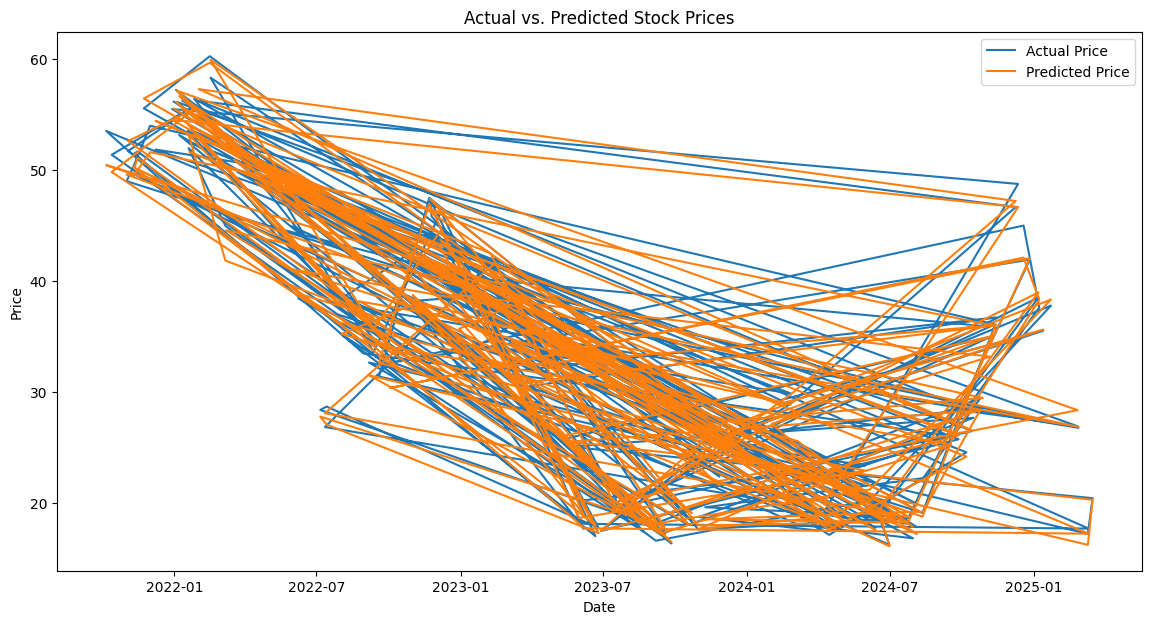

In [83]:
# define plot
plt.figure(figsize=(14, 7))

# data
plt.plot(y_test.index, y_test.values, label='Actual Price')
plt.plot(y_test.index, predictions, label='Predicted Price')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()

plt.show()

## Implementation

Implement a basic trading strategy based on the predictions that will buy when the predicted price is higher than the current price and sell when lower.

In [84]:
""" initial_balance = 10000  # starting balance (USD)
balance = initial_balance
position = 0  # no. of shares

for i in range(len(X_test)):
    current_price = X_test.iloc[i]['Close']
    predicted_price = predictions[i]

    if predicted_price > current_price and balance >= current_price:
        # buy stock
        shares_to_buy = int(balance // current_price)  # buy whole shares only
        if shares_to_buy > 0:
            # buy at least one share
            position += shares_to_buy
            balance -= shares_to_buy * current_price
            print('Buying {shares_to_buy} shares at {current_price}')

    elif predicted_price < current_price and position > 0:
        # sell stock
        balance += position * current_price
        print('Selling {position} shares at {current_price}')
        position = 0

# calculate final balance including the value of the remaining shares
final_balance = balance + (position * X_test.iloc[-1]['Close'])
profit = final_balance - initial_balance

print(f"Final balance: ${final_balance:.2f}")
print(f"Profit: ${profit:.2f}") """

' initial_balance = 10000  # starting balance (USD)\nbalance = initial_balance\nposition = 0  # no. of shares\n\nfor i in range(len(X_test)):\n    current_price = X_test.iloc[i][\'Close\']\n    predicted_price = predictions[i]\n\n    if predicted_price > current_price and balance >= current_price:\n        # buy stock\n        shares_to_buy = int(balance // current_price)  # buy whole shares only\n        if shares_to_buy > 0:\n            # buy at least one share\n            position += shares_to_buy\n            balance -= shares_to_buy * current_price\n            print(\'Buying {shares_to_buy} shares at {current_price}\')\n\n    elif predicted_price < current_price and position > 0:\n        # sell stock\n        balance += position * current_price\n        print(\'Selling {position} shares at {current_price}\')\n        position = 0\n\n# calculate final balance including the value of the remaining shares\nfinal_balance = balance + (position * X_test.iloc[-1][\'Close\'])\nprofit =

# LSTM Model

## Preprocess Data

In [85]:
# use closing prices for prediction
close = stock_data['Close'].values

# normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close.reshape(-1,1))

# split into training and test data
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [86]:
# create sequences of past stock prices (features, x) and next stock price (target, y)
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# create sequences from training and test data
seq_length = 60         # use previous 60 days to predict next day's price
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# reshape the input data to be compatible with LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Build LSTM Model

In [87]:
# initialize model
model = Sequential()

# add LSTM layers
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# add output layer
model.add(Dense(units=1))

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# train model
model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0673
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0067
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0047
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0040
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0040
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0037
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0036
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0036
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0038
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0031
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0037
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0033
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0028
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0027
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0026
Epoch 16/20
20/

## Predictions

In [88]:
# predict stock prices on test data
predictions = model.predict(x_test)

# inverse transform predictions back to original price scale
predictions = scaler.inverse_transform(predictions)

# inverse transform actual test data
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


## Evaluation

In [89]:
# calculate MSE, RMSE, R^2
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Mean Squared Error: 6.652420008836187
Root Mean Squared Error: 2.579228568552269
R² Score: 0.8882214911351373


## Visualizations

In [90]:
fig = go.Figure()

# actual prices
fig.add_trace(go.Scatter(x=stock_data.index[-len(y_test):],
                         y=y_test_scaled.flatten(),
                         mode='lines',
                         name='Actual Price'))

# predicted prices
fig.add_trace(go.Scatter(x=stock_data.index[-len(y_test):],
                         y=predictions.flatten(),
                         mode='lines',
                         name='Predicted Price'))

# labels
fig.update_layout(title='VS Stock Prediction',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (USD)')

fig.show()